In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 20
import matplotlib.patches as mpatches

In [2]:
from jemupk import *

In [3]:
emu = JemuPk()
root_dir = "./"
emu.load_all_gps(directory = root_dir + '/pknl_components' + st.d_one_plus)

New Pk Emulator


In [4]:
import jax_cosmo as jc
import pyccl as ccl

In [5]:
#Omega_cdm h^2, Omega_b h^2, ln(10^10 As), ns, h
#cosmologies[0]=array([0.12616742, 0.02163407, 2.72607173, 1.15724975, 0.73022459])
h_emu = 0.73022459
omega_c_emu = 0.12616742    # omega_c h^2
omega_b_emu = 0.02163407   #omega_b h^2
n_s_emu = 1.15724975
ln1010As_emu = 2.72607173
As_emu = 10**(-10)*np.exp(ln1010As_emu)

In [6]:
omega_c_ccl = omega_c_emu/h_emu**2
omega_b_ccl = omega_b_emu/h_emu**2


sigma8_emu = ccl.Cosmology(
    Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, A_s=As_emu, n_s=n_s_emu, Neff=0,
    transfer_function='boltzmann_camb').sigma8()

cosmo_ccl= ccl.Cosmology(
    Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Neff=0,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')

In [7]:
params_emu = {'omega_cdm': omega_c_emu, 'omega_b': omega_b_emu, 
             'ln10^{10}A_s':ln1010As_emu , 
             'n_s': n_s_emu, 'h': h_emu}
theta_star = jnp.array([val for val in params_emu.values()])
#Omega_cdm h^2, Omega_b h^2, ln(10^10 As), ns, h
theta_star

DeviceArray([0.12616742, 0.02163407, 2.72607173, 1.15724975, 0.73022459],            dtype=float64)

In [8]:
Nk=10*st.nk 
k_star = jnp.geomspace(5e-4, 5e1,Nk, endpoint=True)
z_star = jnp.array([0.,1.22631579])
pk_nl, gf, pk_lz0 = emu.interp_pk(theta_star, k_star,z_star, grid_opt=True)

2022-05-24 11:40:11.746454: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[16,800]{1,0} custom-call(f64[16,16]{1,0} %multiply.16, f64[16,800]{1,0} %concatenate.744), custom_call_target="__cublas$gemm", metadata={op_type="dot_general" op_name="jit(jec_interp2d_v2)/dot_general[\n  dimension_numbers=(((1,), (0,)), ((), ()))\n  precision=None\n  preferred_element_type=None\n]" source_file="/sps/lsst/users/campagne/Jemu/util.py" source_line=82}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"0\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"256\",\"rhs_stride\":\"12800\"}" failed. Falling back to default algorithm. 


In [9]:
pk_nl.shape, gf.shape, pk_lz0.shape

((2, 400), (2,), (400,))

In [10]:
pk_nl /= h_emu**2
pk_lz0 /= h_emu**2

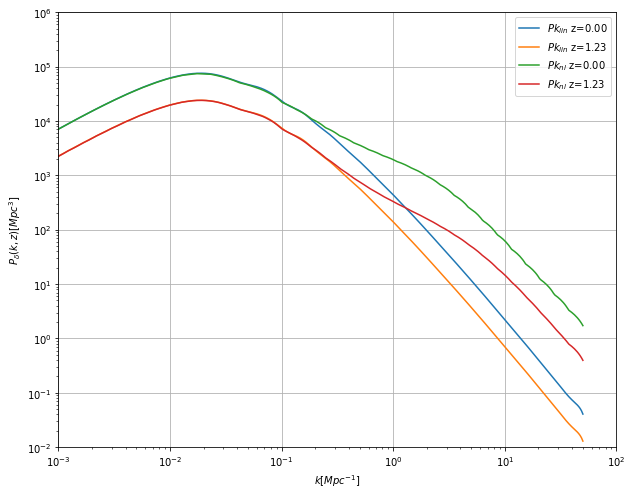

In [11]:
plt.figure(figsize=(10,8))
plt.plot(k_star, pk_lz0*gf[0],label=fr"$Pk_{{lin}}$ z={z_star[0]:.2f}")
plt.plot(k_star, pk_lz0*gf[1],label=fr"$Pk_{{lin}}$ z={z_star[1]:.2f}")
plt.plot(k_star, pk_nl[0], label=fr"$Pk_{{nl}}$ z={z_star[0]:.2f}")
plt.plot(k_star, pk_nl[1], label=fr"$Pk_{{nl}}$ z={z_star[1]:.2f}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.xlim([1e-3,1e2])
plt.ylim([1e-2,1e6])
plt.legend();

In [12]:
z_ccl = z_star[1].item()


cosmo_jax = jc.Cosmology(Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Omega_k=0, w0=-1.0,wa=0.0)

pk_lin_ccl = ccl.linear_matter_power(cosmo_ccl, k_star*cosmo_jax.h, 1./(1+z_ccl)) #last is scale factor 1=>z=0

pk_lin_jc = jc.power.linear_matter_power(cosmo_jax,k_star, 1./(1+z_ccl))/cosmo_jax.h**3

(0.01, 1000000.0)

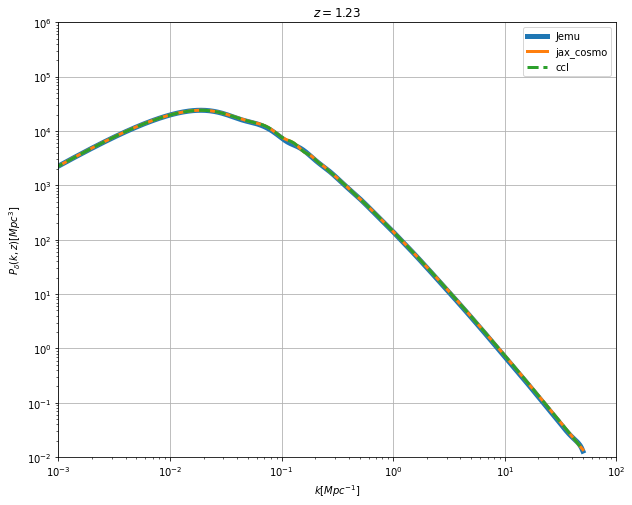

In [13]:
plt.figure(figsize=(10,8))
plt.plot(k_star,pk_lz0*gf[1],lw=5, label="Jemu")
plt.plot(k_star,pk_lin_jc,lw=3, label="jax_cosmo")
plt.plot(k_star,pk_lin_ccl,lw=3, ls="--",label="ccl")
#plt.plot(k_star,pk_nl, lw=1,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.title(rf"$z={z_ccl:.2f}$");
plt.xlim([1e-3,1e2])
plt.ylim([1e-2,1e6])

In [14]:
cosmo_ccl_EH= ccl.Cosmology(
    Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Neff=0,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')


pk_nonlin_ccl_EH = ccl.nonlin_matter_power(cosmo_ccl_EH, k_star*cosmo_jax.h, 
                                        1./(1+z_ccl)) #last is scale factor 1=>z=0


pk_nonlin_jc = jc.power.nonlinear_matter_power(cosmo_jax,k_star, 
                                               1./(1+z_ccl))/cosmo_jax.h**3

(0.01, 1000000.0)

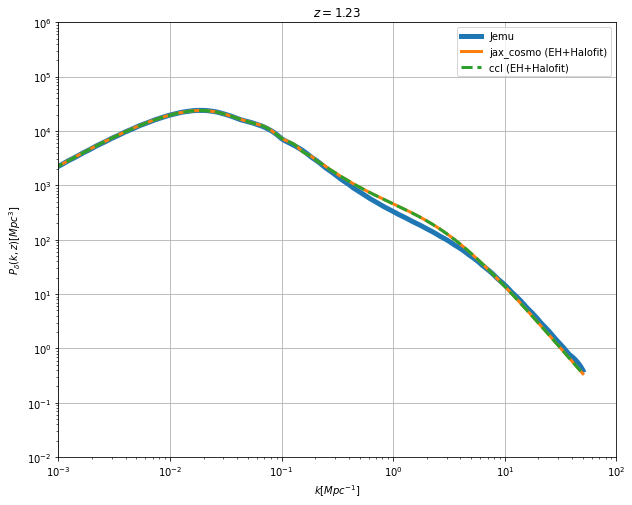

In [15]:
plt.figure(figsize=(10,8))
plt.plot(k_star,pk_nl[1],lw=5, label="Jemu")
plt.plot(k_star,pk_nonlin_jc,lw=3, label="jax_cosmo (EH+Halofit)")
plt.plot(k_star,pk_nonlin_ccl_EH,lw=3, ls="--",label="ccl (EH+Halofit)")
#plt.plot(k_star,pk_nl, lw=1,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.title(rf"$z={z_ccl:.2f}$");
plt.xlim([1e-3,1e2])
plt.ylim([1e-2,1e6])